# ML Assignment 5: Naive Bayes and Decision Tree on Churn Dataset

## Objective
Apply Naive Bayes and Decision Tree algorithms to predict customer churn and analyze how model parameters affect performance.

---

## Step 1: Import Required Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Load and Explore the Dataset

In [32]:
# Load the dataset
df = pd.read_csv('churn_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Variable Distribution:")
print(df['Churn'].value_counts())

Dataset Shape: (7043, 21)

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Strea

### 2.1 Detailed Data Exploration

In [33]:
# Detailed exploration of the dataset
print("="*80)
print("DETAILED DATA EXPLORATION")
print("="*80)

print("\n1. Dataset Dimensions:")
print(f"   - Number of rows: {df.shape[0]:,}")
print(f"   - Number of columns: {df.shape[1]}")

print("\n2. Data Types Summary:")
print(df.dtypes.value_counts())

print(f"\n3. Duplicate Rows: {df.duplicated().sum()}")

print("\n4. Missing Values Analysis:")
missing = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("   No missing values detected initially!")

print("\n5. TotalCharges Column Analysis:")
print(f"   - Data Type: {df['TotalCharges'].dtype}")
print(f"   - Sample values: {df['TotalCharges'].head(10).tolist()}")

# Check for non-numeric values in TotalCharges
try:
    # Try to convert to numeric - this will reveal any issues
    total_charges_numeric = pd.to_numeric(df['TotalCharges'], errors='coerce')
    non_numeric_count = total_charges_numeric.isnull().sum() - df['TotalCharges'].isnull().sum()
    print(f"   - Non-numeric values found: {non_numeric_count}")
    if non_numeric_count > 0:
        print(f"   - These are likely spaces ' ' or empty strings that need conversion!")
except:
    print("   - Unable to analyze TotalCharges for non-numeric values")

print("\n6. Numerical Features Statistics:")
print(df.describe())

print("\n7. Categorical Features:")
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"   Total categorical features: {len(categorical_features)}")
print(f"   Features: {categorical_features}")

print("\n8. Target Variable (Churn) Distribution:")
churn_counts = df['Churn'].value_counts()
churn_percent = df['Churn'].value_counts(normalize=True) * 100
print(f"   - No:  {churn_counts.get('No', 0):,} ({churn_percent.get('No', 0):.2f}%)")
print(f"   - Yes: {churn_counts.get('Yes', 0):,} ({churn_percent.get('Yes', 0):.2f}%)")
print(f"   - Class Imbalance Ratio: {churn_counts.max() / churn_counts.min():.2f}:1")

print("\n9. Unique Values in Categorical Features:")
for col in categorical_features[:10]:  # Show first 10
    unique_count = df[col].nunique()
    print(f"   - {col}: {unique_count} unique values")

print("\n" + "="*80)

DETAILED DATA EXPLORATION

1. Dataset Dimensions:
   - Number of rows: 7,043
   - Number of columns: 21

2. Data Types Summary:
object     18
int64       2
float64     1
Name: count, dtype: int64

3. Duplicate Rows: 0

4. Missing Values Analysis:
   No missing values detected initially!

5. TotalCharges Column Analysis:
   - Data Type: object
   - Sample values: ['29.85', '1889.5', '108.15', '1840.75', '151.65', '820.5', '1949.4', '301.9', '3046.05', '3487.95']
   - Non-numeric values found: 11
   - These are likely spaces ' ' or empty strings that need conversion!

6. Numerical Features Statistics:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.

## Step 3: Data Preprocessing

### 3.1 Handle Missing Values and Data Cleaning

In [34]:
# Handle TotalCharges - it appears numeric but contains spaces ' ' for some customers with 0 tenure
# These spaces cannot be used in calculations, so we convert to numeric (coerce turns invalid values to NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many missing values we now have
print(f"Missing values in TotalCharges after conversion: {df['TotalCharges'].isnull().sum()}")

# Fill missing TotalCharges with median (reasonable since they're likely new customers)
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID as it's not useful for prediction
df = df.drop('customerID', axis=1)

print("\nData cleaned successfully!")
print(f"Remaining missing values: {df.isnull().sum().sum()}")
print(f"Final dataset shape: {df.shape}")

Missing values in TotalCharges after conversion: 11

Data cleaned successfully!
Remaining missing values: 0
Final dataset shape: (7043, 20)


### 3.2 Encode Categorical Variables

In [35]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Encode binary categorical variables (Yes/No, Male/Female)
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# One-hot encode multi-category variables
multi_cat_cols = [col for col in categorical_cols if col not in binary_cols]
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

print(f"\nDataset shape after encoding: {df.shape}")
print(df.head())

Categorical columns (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Dataset shape after encoding: (7043, 31)
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...

## Step 4: Feature Selection and Train-Test Split

In [36]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts(normalize=True))

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Features shape: (7043, 30)
Target shape: (7043,)

Class distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Training set size: 5634
Test set size: 1409


### 4.1 Feature Scaling (for Naive Bayes)

In [37]:
# Scale features for Naive Bayes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")

Features scaled successfully!



## Step 5: Naive Bayes Implementation

### 5.1 Train Basic Naive Bayes Model

In [38]:
# Create and train Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test_scaled)
y_pred_proba_nb = nb_model.predict_proba(X_test_scaled)[:, 1]

print("Naive Bayes model trained successfully!")

Naive Bayes model trained successfully!


### 5.2 Evaluate Naive Bayes Performance

In [39]:
# Calculate metrics
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb)
nb_recall = recall_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb)
nb_auc = roc_auc_score(y_test, y_pred_proba_nb)

print("=" * 50)
print("NAIVE BAYES PERFORMANCE")
print("=" * 50)
print(f"Accuracy:  {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall:    {nb_recall:.4f}")
print(f"F1-Score:  {nb_f1:.4f}")
print(f"ROC-AUC:   {nb_auc:.4f}")
print("=" * 50)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['No Churn', 'Churn']))

NAIVE BAYES PERFORMANCE
Accuracy:  0.6941
Precision: 0.4600
Recall:    0.8770
F1-Score:  0.6035
ROC-AUC:   0.8334

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.93      0.63      0.75      1035
       Churn       0.46      0.88      0.60       374

    accuracy                           0.69      1409
   macro avg       0.70      0.75      0.68      1409
weighted avg       0.81      0.69      0.71      1409

              precision    recall  f1-score   support

    No Churn       0.93      0.63      0.75      1035
       Churn       0.46      0.88      0.60       374

    accuracy                           0.69      1409
   macro avg       0.70      0.75      0.68      1409
weighted avg       0.81      0.69      0.71      1409



### 5.3 Naive Bayes Confusion Matrix

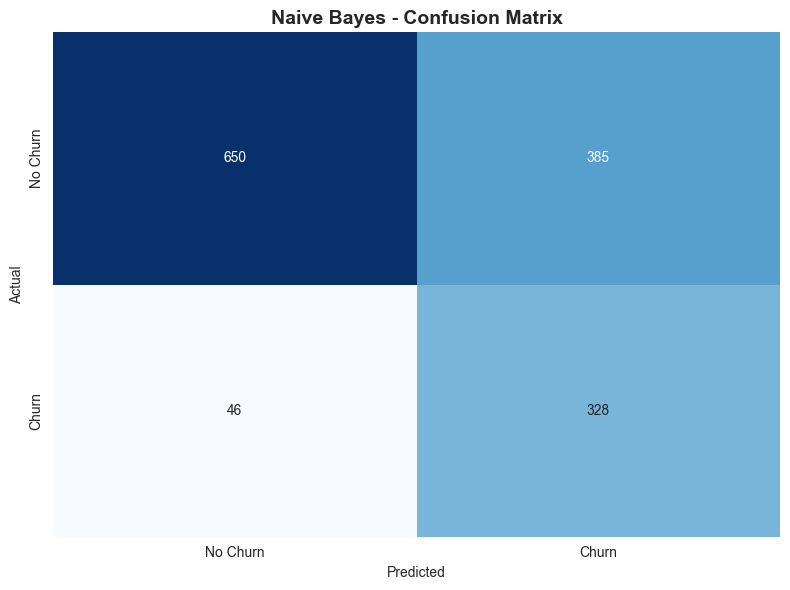

In [40]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Naive Bayes - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

### 5.4 Naive Bayes Parameter Tuning (var_smoothing)

**What is var_smoothing?**
- Adds a small value to variances to prevent division by zero
- Controls smoothness of probability estimates
- Default: 1e-9 (0.000000001)
- Higher values = More smoothing = Simpler model
- Lower values = Less smoothing = More complex model

In [ ]:
# Test different var_smoothing values
var_smoothing_values = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
nb_results = []

print("Testing different var_smoothing values...\n")

for var_smooth in var_smoothing_values:
    # Train model
    nb = GaussianNB(var_smoothing=var_smooth)   
    nb.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = nb.predict(X_test_scaled)
    y_pred_proba = nb.predict_proba(X_test_scaled)[:, 1]
    
    # Store metrics
    nb_results.append({
        'var_smoothing': f'{var_smooth:.0e}',
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    })

# Create results dataframe
nb_results_df = pd.DataFrame(nb_results)
print("Performance across different var_smoothing values:")
print(nb_results_df.to_string(index=False))

Testing different var_smoothing values...

Performance across different var_smoothing values:
var_smoothing  accuracy  precision   recall  f1_score  roc_auc
        1e-12  0.694109   0.460028 0.877005  0.603496  0.83339
        1e-11  0.694109   0.460028 0.877005  0.603496  0.83339
        1e-10  0.694109   0.460028 0.877005  0.603496  0.83339
        1e-09  0.694109   0.460028 0.877005  0.603496  0.83339
        1e-08  0.694109   0.460028 0.877005  0.603496  0.83339
        1e-07  0.694109   0.460028 0.877005  0.603496  0.83339
        1e-06  0.694109   0.460028 0.877005  0.603496  0.83339
        1e-05  0.694109   0.460028 0.877005  0.603496  0.83339
Performance across different var_smoothing values:
var_smoothing  accuracy  precision   recall  f1_score  roc_auc
        1e-12  0.694109   0.460028 0.877005  0.603496  0.83339
        1e-11  0.694109   0.460028 0.877005  0.603496  0.83339
        1e-10  0.694109   0.460028 0.877005  0.603496  0.83339
        1e-09  0.694109   0.460028 0

### 5.5 Visualize Effect of var_smoothing

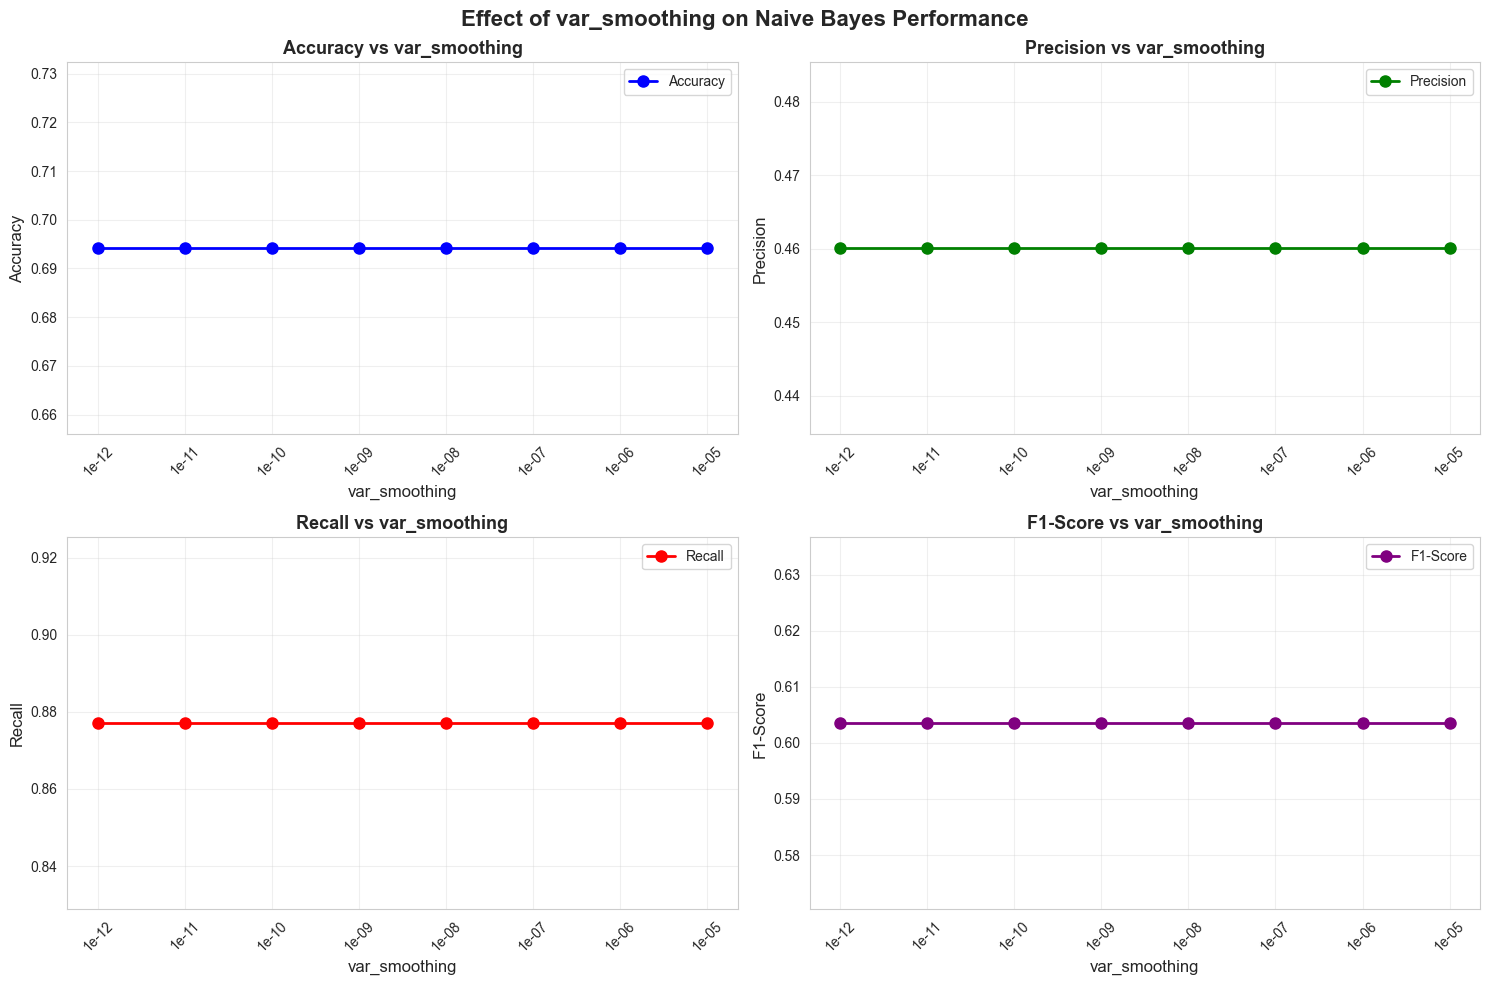

In [42]:
# Plot metrics vs var_smoothing
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Effect of var_smoothing on Naive Bayes Performance', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['blue', 'green', 'red', 'purple']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx // 2, idx % 2]
    ax.plot(range(len(nb_results_df)), nb_results_df[metric], marker='o', 
            linewidth=2, markersize=8, color=color, label=title)
    ax.set_xlabel('var_smoothing', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} vs var_smoothing', fontsize=13, fontweight='bold')
    ax.set_xticks(range(len(nb_results_df)))
    ax.set_xticklabels(nb_results_df['var_smoothing'], rotation=45)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

### 5.6 Grid Search for Optimal Naive Bayes Parameters

In [43]:
# Define parameter grid for Naive Bayes
nb_param_grid = {
    'var_smoothing': np.logspace(-12, -5, 20)  # 20 values between 1e-12 and 1e-5
}

print("Performing Grid Search for Naive Bayes...")
nb_grid_search = GridSearchCV(GaussianNB(), 
                               nb_param_grid, 
                               cv=5, 
                               scoring='f1',
                               n_jobs=-1,
                               verbose=1)
nb_grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*50)
print("NAIVE BAYES GRID SEARCH RESULTS")
print("="*50)
print(f"Best Parameter: {nb_grid_search.best_params_}")
print(f"Best Cross-Validation F1-Score: {nb_grid_search.best_score_:.4f}")
print("="*50)

Performing Grid Search for Naive Bayes...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

NAIVE BAYES GRID SEARCH RESULTS
Best Parameter: {'var_smoothing': np.float64(1e-12)}
Best Cross-Validation F1-Score: 0.5775

NAIVE BAYES GRID SEARCH RESULTS
Best Parameter: {'var_smoothing': np.float64(1e-12)}
Best Cross-Validation F1-Score: 0.5775


### 5.7 Evaluate Optimized Naive Bayes

In [44]:
# Get best Naive Bayes model
best_nb = nb_grid_search.best_estimator_

# Make predictions
y_pred_best_nb = best_nb.predict(X_test_scaled)
y_pred_proba_best_nb = best_nb.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
best_nb_accuracy = accuracy_score(y_test, y_pred_best_nb)
best_nb_precision = precision_score(y_test, y_pred_best_nb)
best_nb_recall = recall_score(y_test, y_pred_best_nb)
best_nb_f1 = f1_score(y_test, y_pred_best_nb)
best_nb_auc = roc_auc_score(y_test, y_pred_proba_best_nb)

print("\n" + "="*50)
print("OPTIMIZED NAIVE BAYES PERFORMANCE")
print("="*50)
print(f"Best var_smoothing: {nb_grid_search.best_params_['var_smoothing']:.2e}")
print(f"Accuracy:  {best_nb_accuracy:.4f}")
print(f"Precision: {best_nb_precision:.4f}")
print(f"Recall:    {best_nb_recall:.4f}")
print(f"F1-Score:  {best_nb_f1:.4f}")
print(f"ROC-AUC:   {best_nb_auc:.4f}")
print("="*50)

# Compare with default Naive Bayes
print("\n   Improvement from Default:")
print(f"   Accuracy:  {nb_accuracy:.4f} → {best_nb_accuracy:.4f} ({best_nb_accuracy - nb_accuracy:+.4f})")
print(f"   Precision: {nb_precision:.4f} → {best_nb_precision:.4f} ({best_nb_precision - nb_precision:+.4f})")
print(f"   Recall:    {nb_recall:.4f} → {best_nb_recall:.4f} ({best_nb_recall - nb_recall:+.4f})")
print(f"   F1-Score:  {nb_f1:.4f} → {best_nb_f1:.4f} ({best_nb_f1 - nb_f1:+.4f})")
print(f"   ROC-AUC:   {nb_auc:.4f} → {best_nb_auc:.4f} ({best_nb_auc - nb_auc:+.4f})")


OPTIMIZED NAIVE BAYES PERFORMANCE
Best var_smoothing: 1.00e-12
Accuracy:  0.6941
Precision: 0.4600
Recall:    0.8770
F1-Score:  0.6035
ROC-AUC:   0.8334

   Improvement from Default:
   Accuracy:  0.6941 → 0.6941 (+0.0000)
   Precision: 0.4600 → 0.4600 (+0.0000)
   Recall:    0.8770 → 0.8770 (+0.0000)
   F1-Score:  0.6035 → 0.6035 (+0.0000)
   ROC-AUC:   0.8334 → 0.8334 (+0.0000)


### 5.8 Compare Default vs Optimized Naive Bayes

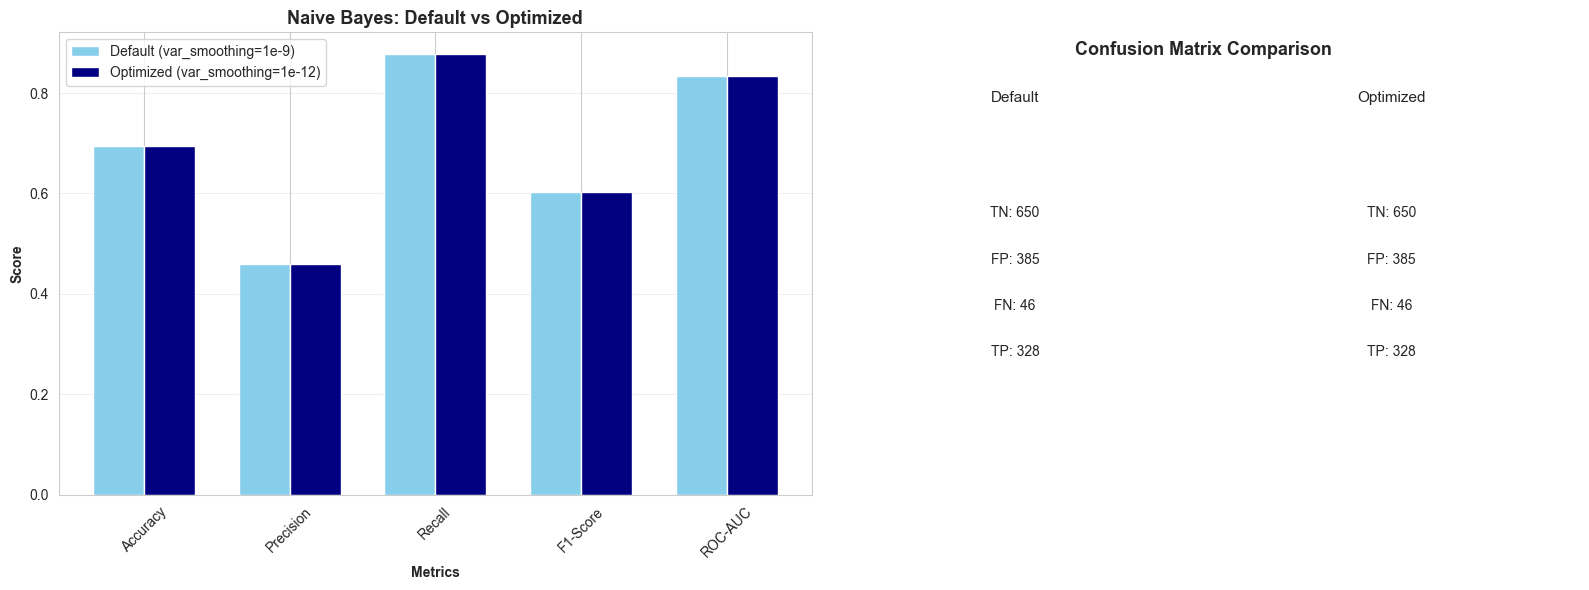

In [45]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
nb_default = [nb_accuracy, nb_precision, nb_recall, nb_f1, nb_auc]
nb_optimized = [best_nb_accuracy, best_nb_precision, best_nb_recall, best_nb_f1, best_nb_auc]

# Bar chart comparison
x = np.arange(len(metrics_list))
width = 0.35
axes[0].bar(x - width/2, nb_default, width, label='Default (var_smoothing=1e-9)', color='skyblue')
axes[0].bar(x + width/2, nb_optimized, width, label=f'Optimized (var_smoothing={nb_grid_search.best_params_["var_smoothing"]:.0e})', color='navy')
axes[0].set_xlabel('Metrics', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Naive Bayes: Default vs Optimized', fontweight='bold', fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_list, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Confusion matrices side by side
cm_default = confusion_matrix(y_test, y_pred_nb)
cm_optimized = confusion_matrix(y_test, y_pred_best_nb)

# Calculate improvement
improvement = cm_optimized - cm_default
axes[1].text(0.5, 0.95, 'Confusion Matrix Comparison', 
             transform=axes[1].transAxes, ha='center', fontsize=13, fontweight='bold')
axes[1].text(0.25, 0.85, 'Default', transform=axes[1].transAxes, ha='center', fontsize=11)
axes[1].text(0.75, 0.85, 'Optimized', transform=axes[1].transAxes, ha='center', fontsize=11)

# Display confusion matrices as text
axes[1].text(0.25, 0.6, f'TN: {cm_default[0][0]}', transform=axes[1].transAxes, ha='center')
axes[1].text(0.25, 0.5, f'FP: {cm_default[0][1]}', transform=axes[1].transAxes, ha='center')
axes[1].text(0.25, 0.4, f'FN: {cm_default[1][0]}', transform=axes[1].transAxes, ha='center')
axes[1].text(0.25, 0.3, f'TP: {cm_default[1][1]}', transform=axes[1].transAxes, ha='center')

axes[1].text(0.75, 0.6, f'TN: {cm_optimized[0][0]}', transform=axes[1].transAxes, ha='center')
axes[1].text(0.75, 0.5, f'FP: {cm_optimized[0][1]}', transform=axes[1].transAxes, ha='center')
axes[1].text(0.75, 0.4, f'FN: {cm_optimized[1][0]}', transform=axes[1].transAxes, ha='center')
axes[1].text(0.75, 0.3, f'TP: {cm_optimized[1][1]}', transform=axes[1].transAxes, ha='center')

axes[1].axis('off')

plt.tight_layout()
plt.show()

## Step 6: Decision Tree Implementation

### 6.1 Train Basic Decision Tree Model

In [46]:
# Create and train Decision Tree model with default parameters
dt_model = DecisionTreeClassifier(random_state=52)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print("Decision Tree model trained successfully!")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")

Decision Tree model trained successfully!
Tree depth: 27
Number of leaves: 1102


### 6.2 Evaluate Basic Decision Tree Performance

In [47]:
# Calculate metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_auc = roc_auc_score(y_test, y_pred_proba_dt)

print("=" * 50)
print("DECISION TREE PERFORMANCE (Default Parameters)")
print("=" * 50)
print(f"Accuracy:  {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall:    {dt_recall:.4f}")
print(f"F1-Score:  {dt_f1:.4f}")
print(f"ROC-AUC:   {dt_auc:.4f}")
print("=" * 50)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn']))

DECISION TREE PERFORMANCE (Default Parameters)
Accuracy:  0.7282
Precision: 0.4885
Recall:    0.5107
F1-Score:  0.4993
ROC-AUC:   0.6591

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.82      0.81      0.81      1035
       Churn       0.49      0.51      0.50       374

    accuracy                           0.73      1409
   macro avg       0.65      0.66      0.66      1409
weighted avg       0.73      0.73      0.73      1409



### 6.3 Decision Tree Confusion Matrix

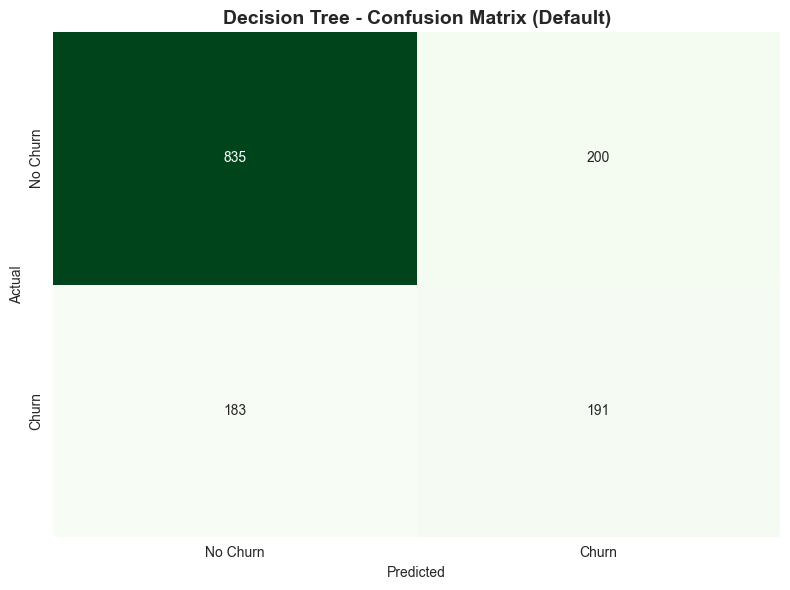

In [48]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Decision Tree - Confusion Matrix (Default)', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## Step 7: Parameter Tuning - Effect of Tree Depth

### 7.1 Experiment with Different Max Depths

In [49]:
# Test different tree depths
max_depths = [2, 3, 5, 7, 10, 15, 20, None]
results = []

for depth in max_depths:
    # Train model
    dt = DecisionTreeClassifier(max_depth=depth, random_state=52)
    dt.fit(X_train, y_train)
    
    # Predictions
    y_pred = dt.predict(X_test)
    y_pred_proba = dt.predict_proba(X_test)[:, 1]
    
    # Store metrics
    results.append({
        'max_depth': depth if depth else 'None',
        'actual_depth': dt.get_depth(),
        'n_leaves': dt.get_n_leaves(),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    })

# Create results dataframe
results_df = pd.DataFrame(results)
print("\nPerformance across different tree depths:")
print(results_df.to_string(index=False))


Performance across different tree depths:
max_depth  actual_depth  n_leaves  accuracy  precision   recall  f1_score  roc_auc
        2             2         4  0.806246   0.728507 0.430481  0.541176 0.777025
        3             3         8  0.806246   0.728507 0.430481  0.541176 0.819202
        5             5        32  0.807665   0.697318 0.486631  0.573228 0.842263
        7             7       105  0.794180   0.643836 0.502674  0.564565 0.829063
       10            10       377  0.767211   0.573248 0.481283  0.523256 0.767076
       15            15       868  0.743080   0.516575 0.500000  0.508152 0.676845
       20            20      1065  0.731015   0.493473 0.505348  0.499339 0.658384
     None            27      1102  0.728176   0.488491 0.510695  0.499346 0.659100


### 7.2 Visualize Effect of Tree Depth on Performance

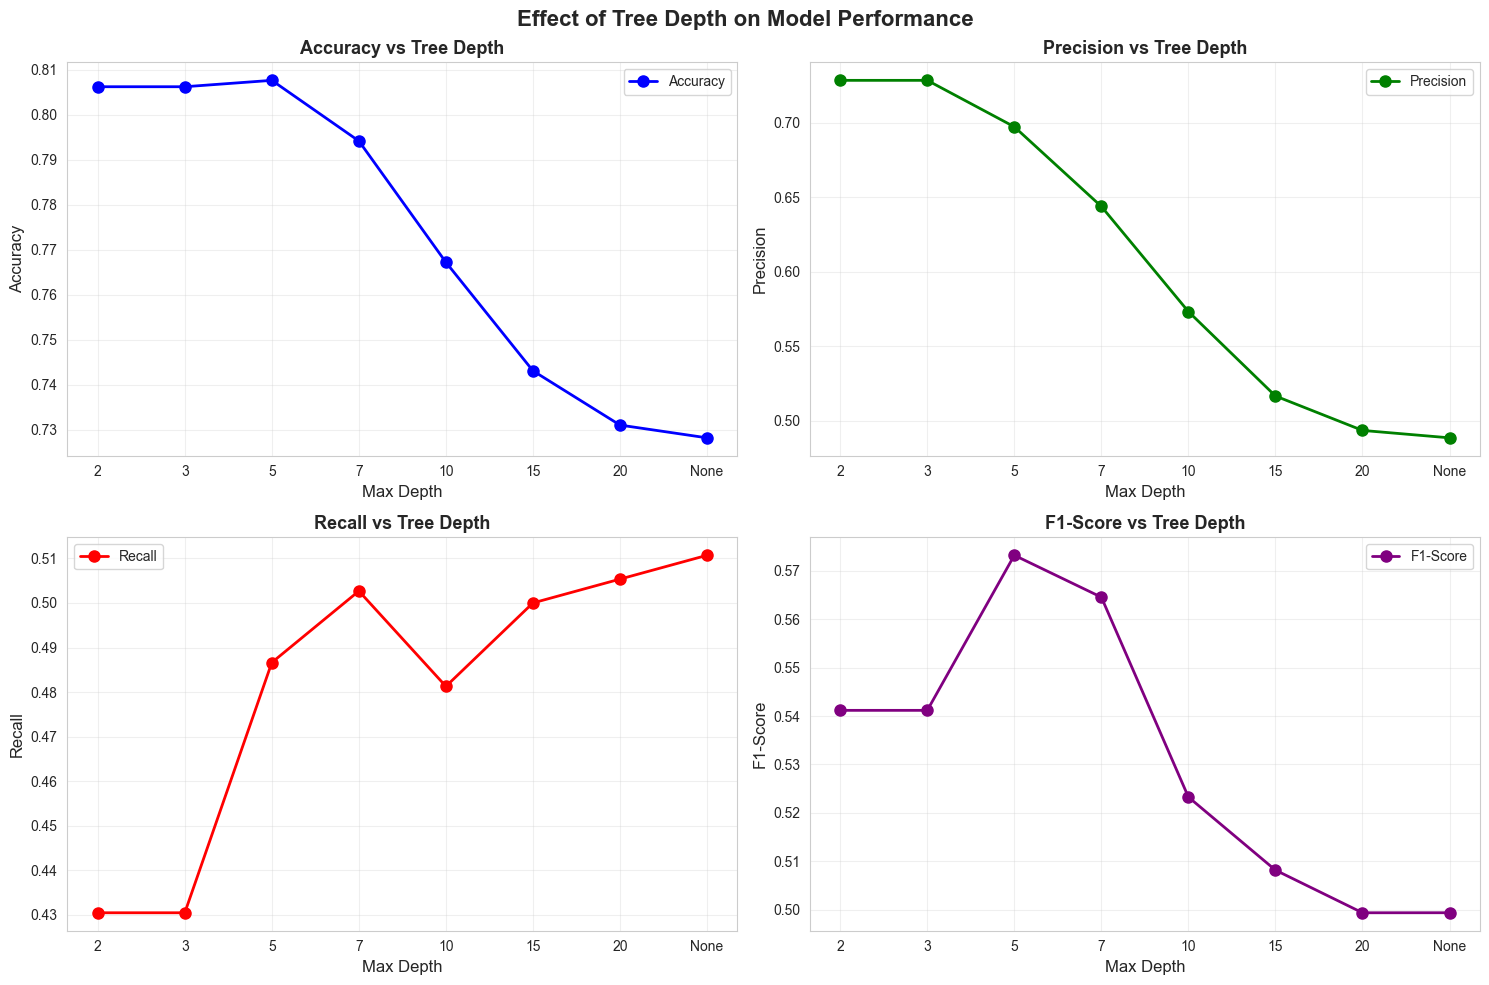

In [50]:
# Plot metrics vs tree depth
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Effect of Tree Depth on Model Performance', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['blue', 'green', 'red', 'purple']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx // 2, idx % 2]
    ax.plot(range(len(results_df)), results_df[metric], marker='o', 
            linewidth=2, markersize=8, color=color, label=title)
    ax.set_xlabel('Max Depth', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} vs Tree Depth', fontsize=13, fontweight='bold')
    ax.set_xticks(range(len(results_df)))
    ax.set_xticklabels(results_df['max_depth'])
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

### 7.3 Compare Training vs Testing Performance (Overfitting Analysis)

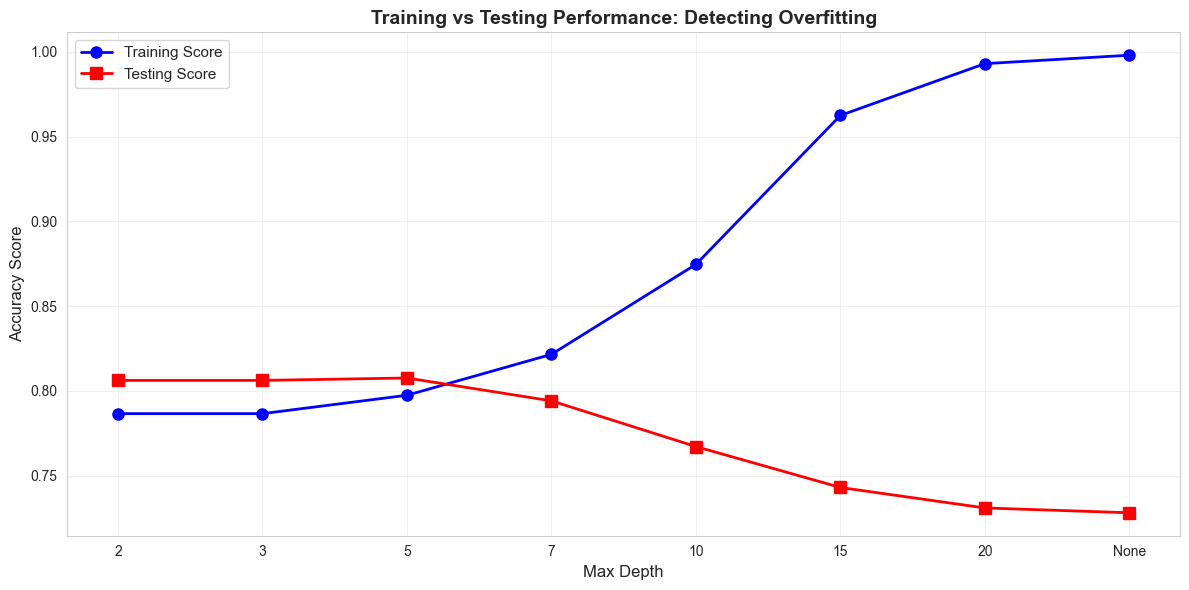


Overfitting Analysis:
Max Depth    2: Gap = -0.0196
Max Depth    3: Gap = -0.0196
Max Depth    5: Gap = -0.0102
Max Depth    7: Gap = 0.0274
Max Depth   10: Gap = 0.1075
Max Depth   15: Gap = 0.2195
Max Depth   20: Gap = 0.2621
Max Depth None: Gap = 0.2699


In [51]:
# Analyze overfitting
train_scores = []
test_scores = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=52)
    dt.fit(X_train, y_train)
    
    train_scores.append(dt.score(X_train, y_train))
    test_scores.append(dt.score(X_test, y_test))

# Plot
plt.figure(figsize=(12, 6))
x_labels = [str(d) if d else 'None' for d in max_depths]
x_pos = range(len(max_depths))

plt.plot(x_pos, train_scores, marker='o', linewidth=2, markersize=8, 
         label='Training Score', color='blue')
plt.plot(x_pos, test_scores, marker='s', linewidth=2, markersize=8, 
         label='Testing Score', color='red')
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Training vs Testing Performance: Detecting Overfitting', 
          fontsize=14, fontweight='bold')
plt.xticks(x_pos, x_labels)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate overfitting gap
overfitting_gap = [train - test for train, test in zip(train_scores, test_scores)]
print("\nOverfitting Analysis:")
for depth, gap in zip(x_labels, overfitting_gap):
    print(f"Max Depth {depth:>4}: Gap = {gap:.4f}")

## Step 8: Additional Parameter Tuning

### 8.1 Effect of Min Samples Split

In [52]:
# Test different min_samples_split values
min_samples_split_values = [2, 10, 20, 50, 100, 200]
split_results = []

for min_split in min_samples_split_values:
    dt = DecisionTreeClassifier(min_samples_split=min_split, random_state=52)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    
    split_results.append({
        'min_samples_split': min_split,
        'tree_depth': dt.get_depth(),
        'n_leaves': dt.get_n_leaves(),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    })

split_df = pd.DataFrame(split_results)
print("\nEffect of Min Samples Split:")
print(split_df.to_string(index=False))


Effect of Min Samples Split:
 min_samples_split  tree_depth  n_leaves  accuracy  f1_score
                 2          27      1102  0.728176  0.499346
                10          22       644  0.760114  0.536986
                20          19       417  0.772889  0.534884
                50          17       223  0.794890  0.584173
               100          15       123  0.801987  0.570108
               200          14        52  0.798439  0.532895


### 8.2 Effect of Min Samples Leaf

In [53]:
# Test different min_samples_leaf values
min_samples_leaf_values = [1, 5, 10, 20, 50, 100]
leaf_results = []

for min_leaf in min_samples_leaf_values:
    dt = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=52)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    
    leaf_results.append({
        'min_samples_leaf': min_leaf,
        'tree_depth': dt.get_depth(),
        'n_leaves': dt.get_n_leaves(),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    })

leaf_df = pd.DataFrame(leaf_results)
print("\nEffect of Min Samples Leaf:")
print(leaf_df.to_string(index=False))


Effect of Min Samples Leaf:
 min_samples_leaf  tree_depth  n_leaves  accuracy  f1_score
                1          27      1102  0.728176  0.499346
                5          19       547  0.769340  0.533716
               10          15       318  0.777147  0.551429
               20          13       180  0.783534  0.553441
               50          10        82  0.797729  0.564885
              100           8        42  0.806246  0.576744


## Step 9: Grid Search for Optimal Parameters

In [54]:
# Define parameter grid
param_grid = {
    'max_depth': [5, 7, 10, 15, 20],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Perform Grid Search
print("Performing Grid Search... This may take a few minutes.")
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=52), 
                           param_grid, 
                           cv=5, 
                           scoring='f1',
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train, y_train)

print("\n" + "="*50)
print("GRID SEARCH RESULTS")
print("="*50)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")
print("="*50)

Performing Grid Search... This may take a few minutes.
Fitting 5 folds for each of 160 candidates, totalling 800 fits

GRID SEARCH RESULTS
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 50}
Best Cross-Validation F1-Score: 0.5509

GRID SEARCH RESULTS
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 50}
Best Cross-Validation F1-Score: 0.5509


### 9.1 Evaluate Optimized Model

In [55]:
# Get best model
best_dt = grid_search.best_estimator_

# Make predictions
y_pred_best = best_dt.predict(X_test)
y_pred_proba_best = best_dt.predict_proba(X_test)[:, 1]

# Calculate metrics
best_accuracy = accuracy_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best)
best_recall = recall_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best)
best_auc = roc_auc_score(y_test, y_pred_proba_best)

print("\n" + "="*50)
print("OPTIMIZED DECISION TREE PERFORMANCE")
print("="*50)
print(f"Accuracy:  {best_accuracy:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall:    {best_recall:.4f}")
print(f"F1-Score:  {best_f1:.4f}")
print(f"ROC-AUC:   {best_auc:.4f}")
print(f"Tree Depth: {best_dt.get_depth()}")
print(f"Number of Leaves: {best_dt.get_n_leaves()}")
print("="*50)


OPTIMIZED DECISION TREE PERFORMANCE
Accuracy:  0.7970
Precision: 0.6467
Recall:    0.5187
F1-Score:  0.5757
ROC-AUC:   0.8355
Tree Depth: 7
Number of Leaves: 61


## Step 10: Model Comparison

### 10.1 Compare All Models

In [56]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Naive Bayes', 'Decision Tree (Default)', 'Decision Tree (Optimized)'],
    'Accuracy': [nb_accuracy, dt_accuracy, best_accuracy],
    'Precision': [nb_precision, dt_precision, best_precision],
    'Recall': [nb_recall, dt_recall, best_recall],
    'F1-Score': [nb_f1, dt_f1, best_f1],
    'ROC-AUC': [nb_auc, dt_auc, best_auc]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)


MODEL COMPARISON SUMMARY
                    Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
              Naive Bayes  0.694109   0.460028 0.877005  0.603496 0.833390
  Decision Tree (Default)  0.728176   0.488491 0.510695  0.499346 0.659100
Decision Tree (Optimized)  0.797019   0.646667 0.518717  0.575668 0.835467


### 10.2 Visualize Model Comparison

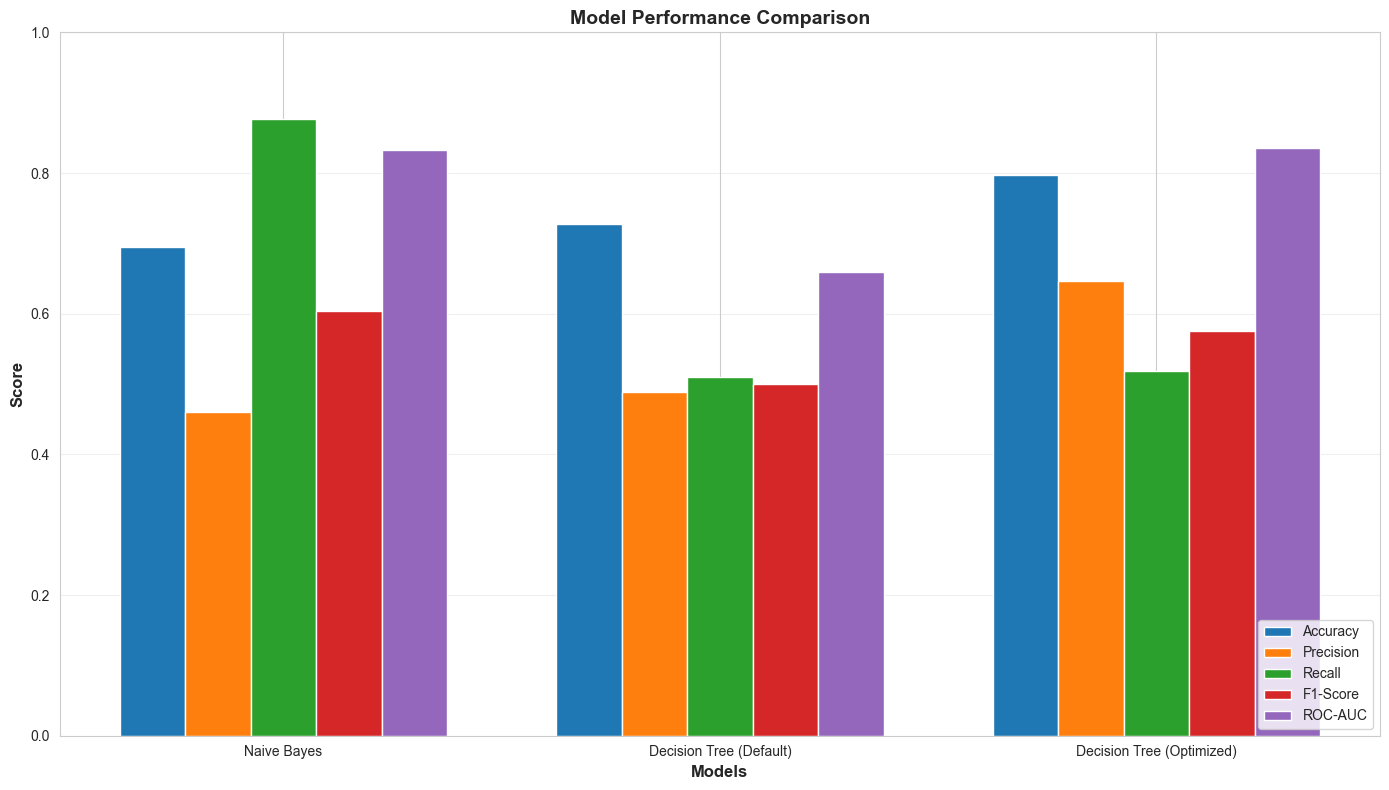

In [57]:
# Bar plot comparison
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(comparison))
width = 0.15
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    offset = width * (i - 2)
    ax.bar(x + offset, comparison[metric], width, label=metric, color=color)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'])
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 10.3 ROC Curve Comparison

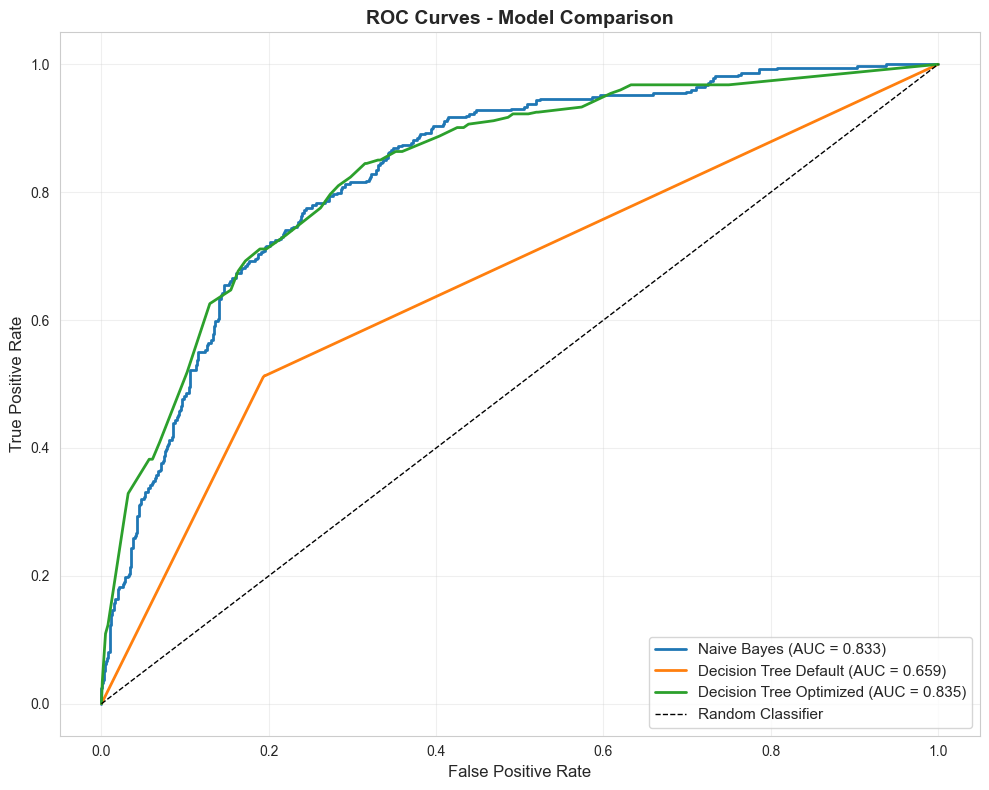

In [58]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Naive Bayes ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_proba_nb)
plt.plot(fpr_nb, tpr_nb, linewidth=2, label=f'Naive Bayes (AUC = {nb_auc:.3f})')

# Decision Tree (Default) ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
plt.plot(fpr_dt, tpr_dt, linewidth=2, label=f'Decision Tree Default (AUC = {dt_auc:.3f})')

# Decision Tree (Optimized) ROC
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
plt.plot(fpr_best, tpr_best, linewidth=2, label=f'Decision Tree Optimized (AUC = {best_auc:.3f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 11: Visualize Decision Tree

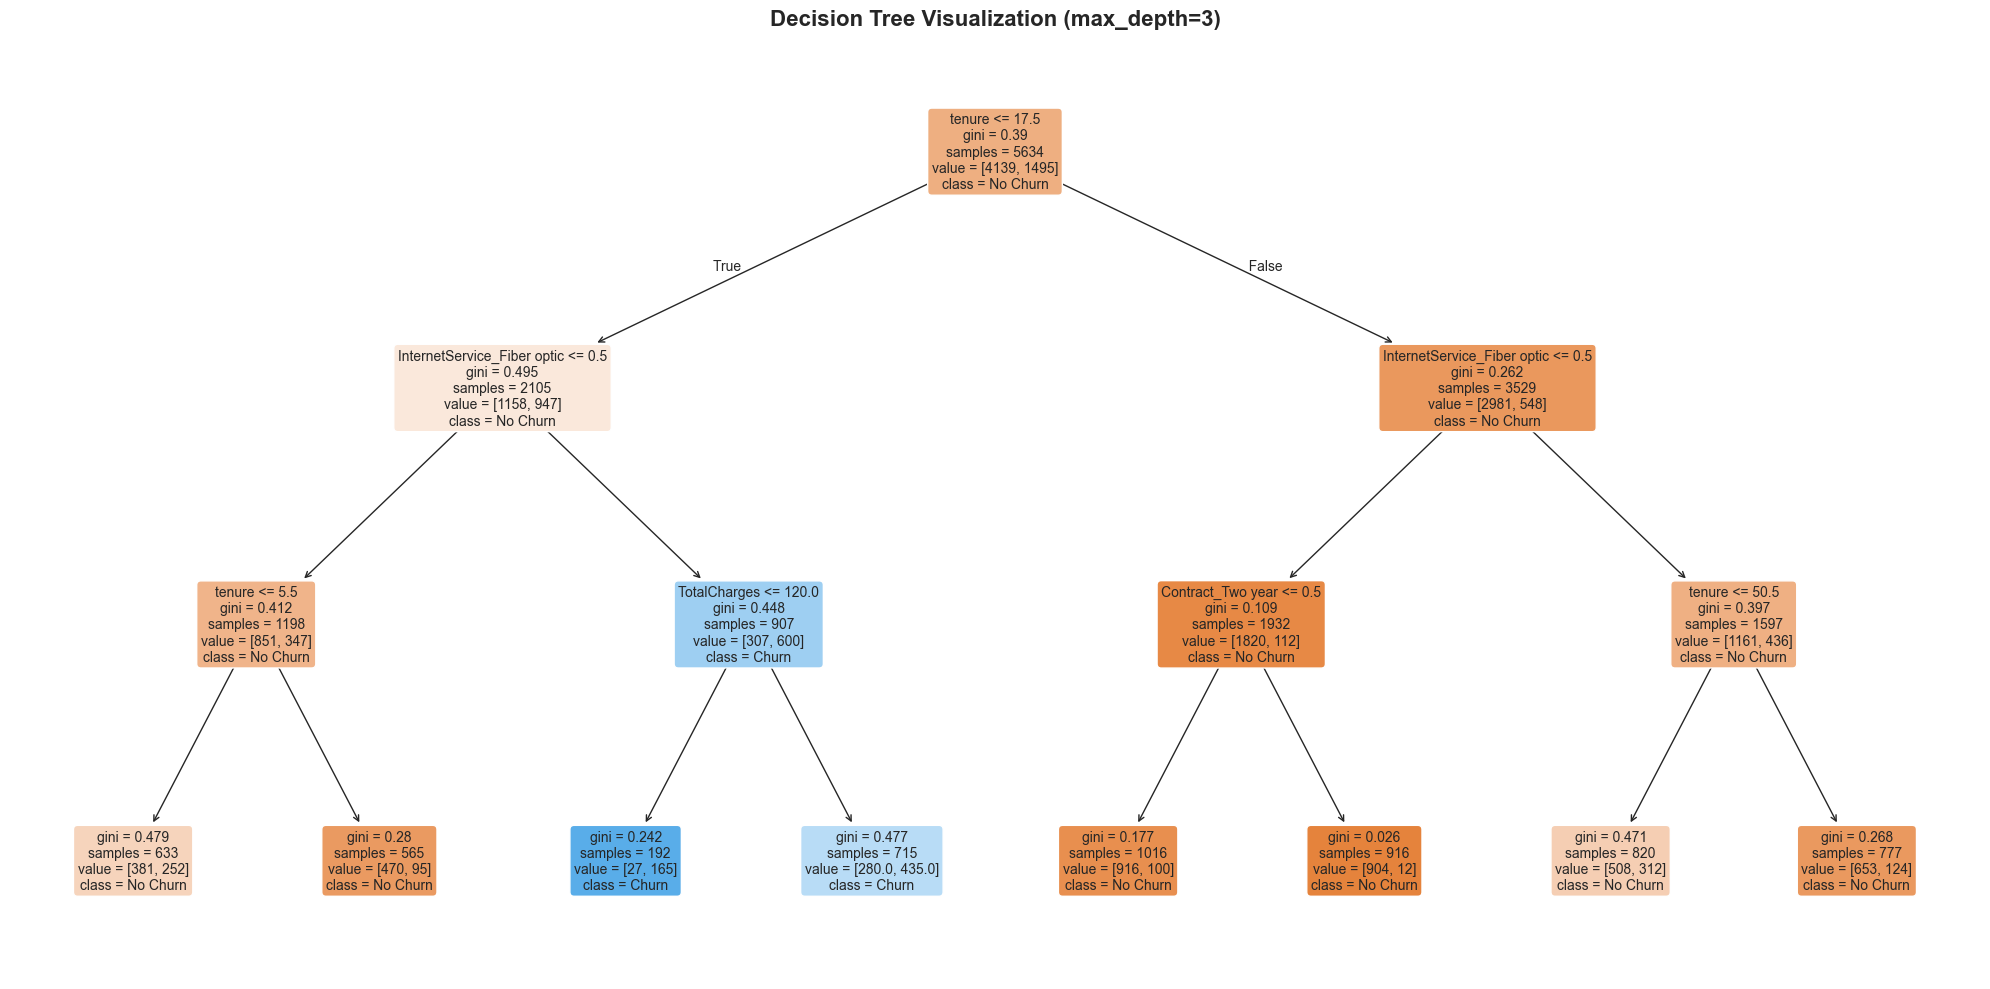

In [59]:
# Visualize a simplified version of the tree (max_depth=3 for visibility)
dt_simple = DecisionTreeClassifier(max_depth=3, random_state=52)
dt_simple.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt_simple, 
          feature_names=X.columns,
          class_names=['No Churn', 'Churn'],
          filled=True,
          fontsize=10,
          rounded=True)
plt.title('Decision Tree Visualization (max_depth=3)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()